In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mping
%matplotlib qt

import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip, ImageClip
from IPython.display import HTML
%matplotlib inline

In [2]:
objpoint=np.zeros((9*6,3),np.float32)
objpoint[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
#print("ObjShape",objpoint)

objpoints=[] #3d points in real world
imagepoints=[] #2d ponits in image plane
objpoints1=[] #3d points in real world
imagepoints1=[] #2d ponits in image plane

images=glob.glob('camera_cal/calibration*.jpg')

for fimages in images:
    img=mping.imread(fimages)
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    ret,corners=cv2.findChessboardCorners(gray,(9,6),None)
    
    if(ret==1):
        
        objpoints.append(objpoint)
        imagepoints.append(corners)
        cv2.drawChessboardCorners(img,(9,6),corners,ret)
        
        cv2.imshow('img', img)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()

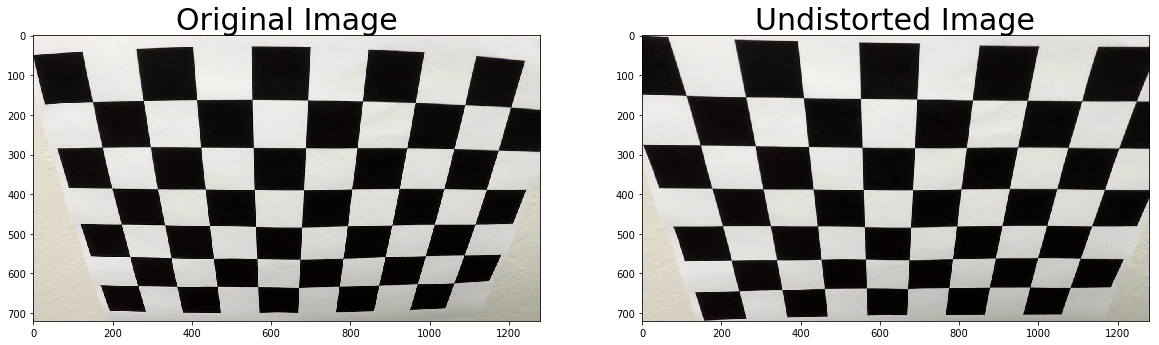

In [3]:
%matplotlib inline
image=mping.imread('camera_cal/calibration2.jpg')
img_size=(image.shape[0],image.shape[1])

ret,mtx,dist,rvec,trvec=cv2.calibrateCamera(objpoints,imagepoints,img_size,None,None)

undistort=cv2.undistort(image,mtx,dist,None,mtx)

cv2.imwrite('output_images/test_undist.jpg',undistort)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=30)

In [391]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(40, 200)):
    # Calculate gradient magnitude
    # Apply threshold
    # Sobel x and y
    kernel_size=9
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #blur_img = cv2.GaussianBlur(img,(kernel_size, kernel_size), 0)
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=13)
    #sobely=cv2.Sobel(gray,cv2.CV_64F,0,1)
    
    #magnitude=np.sqrt(sobelx**2+sobely**2)
    
    abs_sobel_bry=np.uint8(np.abs(sobelx)*255/np.max(np.abs(sobelx)))
    
    scaled_sobel=np.zeros_like(abs_sobel_bry)
    scaled_sobel[(abs_sobel_bry >= mag_thresh[0]) & (abs_sobel_bry <= mag_thresh[1])] = 1
    
    return scaled_sobel

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    kernel_size=9
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #blur_img = cv2.GaussianBlur(img,(kernel_size, kernel_size), 0)
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    magnitude=np.arctan2(np.absolute(sobely), np.absolute(sobelx)) 
    
    #abs_sobel_bry=np.uint8(magnitude*255/np.max(magnitude))
    
    sobel_bny=np.zeros_like(magnitude)
    sobel_bny[(magnitude >= thresh[0]) & (magnitude <=thresh[1])] = 1
    
    return sobel_bny
    
def color_thresh(img, sobel_kernel=3, s_thresh=(100, 255)):
    # Threshold color channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float)
    
    lv_channel=lab[:,:,2]
    r_channel=img[:,:,0]
    b_channel=img[:,:,2]
    
     # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    s_binary_R = np.zeros_like(r_channel)
    s_binary_R[(r_channel >= s_thresh[0]) & (r_channel <= s_thresh[1])] = 1
    
    s_binary_B = np.zeros_like(b_channel)
    s_binary_B[(b_channel >= 10) & (b_channel <= 150)] = 1
    
    s_binary_L = np.zeros_like(l_channel)
    s_binary_L[(l_channel >= 10) & (l_channel <= 150)] = 1
    
    s_binary_LV=np.zeros_like(lv_channel)
    s_binary_LV[(lv_channel >= 160) & (lv_channel <= 255)] = 1

    
    return s_binary,s_binary_R,s_binary_B,s_binary_L,s_binary_LV
    

In [396]:
def color_gradient(img,sobel_kernel=9, s_thresh=(120, 255), sx_thresh=(40, 200)):
    img = np.copy(img)
    
    #grad_binary=grad_sobel(image, sobel_kernel=3, sx_thresh=(10, 200))
    
    sobel_X=mag_thresh(img, sobel_kernel=27, mag_thresh=(10, 200))
    
    dir_Thresh=dir_threshold(img, sobel_kernel=27, thresh=(0.7, 1.3))
    
    
    
    s_binary,s_binary_R,s_binary_B,s_binary_L,s_binary_LV=color_thresh(img, sobel_kernel=27, s_thresh=(120, 255))
    
    sxbinary = np.zeros_like(sobel_X)
    sxbinary[((sobel_X == 1))] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary==1)] = 1
    
    #color_binary = np.dstack(( np.zeros_like(sxbinary),sxbinary,s_binary_R)) * 255
    
    
    return combined_binary,color_binary

In [393]:
def corners_unwarp(img, nx, ny, mtx, dist):

    undistorted=cv2.undistort(img,mtx,dist,None,mtx)

    #gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)

    img_size=(undistort.shape[1], undistort.shape[0])

#     src=np.float32([(585, 465),(203, 720),(1127, 720),(695, 465)])

#     dst=np.float32([(320, 0),(320, 720), (960, 720), 
#                                  (960, 0)
#                                  ])
#     src=np.float32([(591, 465),(199, 720),(1130, 720),(690, 465)])

#     dst=np.float32([(320, 0),(320, 720), (960, 720), 
#                                  (960, 0)
#                                  ])
    src=np.float32([(565, 470),(260, 674),(1048, 674),(720, 470)])

    dst=np.float32([(260, 100),(260, 674), (1048, 674), 
                                 (1048, 100)
                                 ])

    M_unwrap=cv2.getPerspectiveTransform(src,dst)

    Mvin=cv2.getPerspectiveTransform(dst,src)

    wrapped=cv2.warpPerspective(img,M_unwrap,img_size)



    return wrapped, M_unwrap,Mvin,undistorted

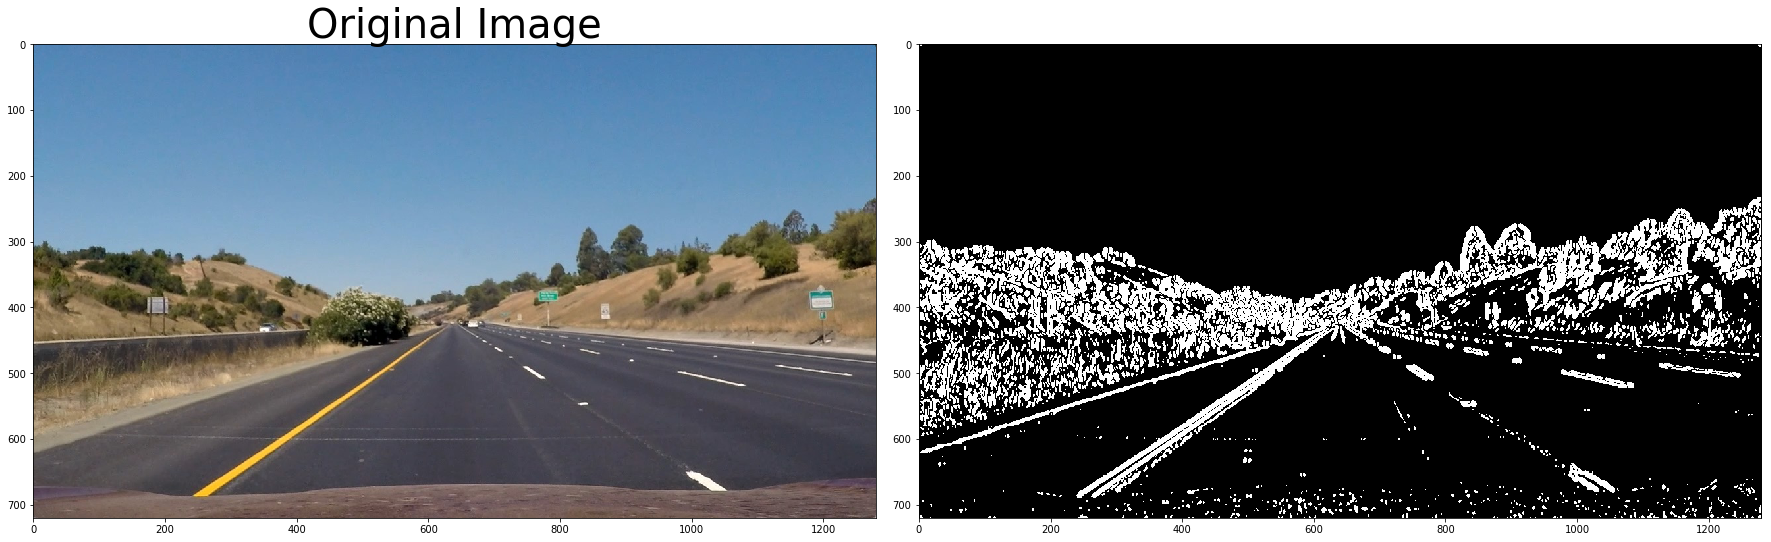

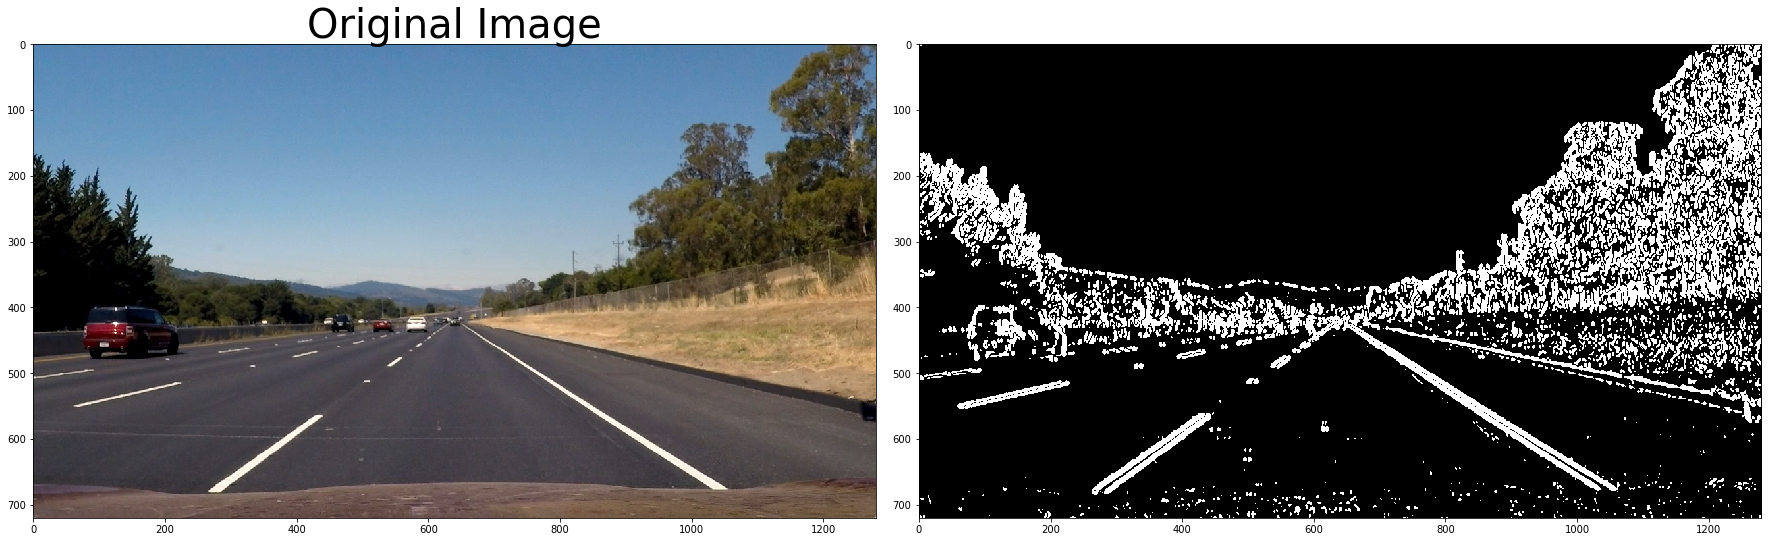

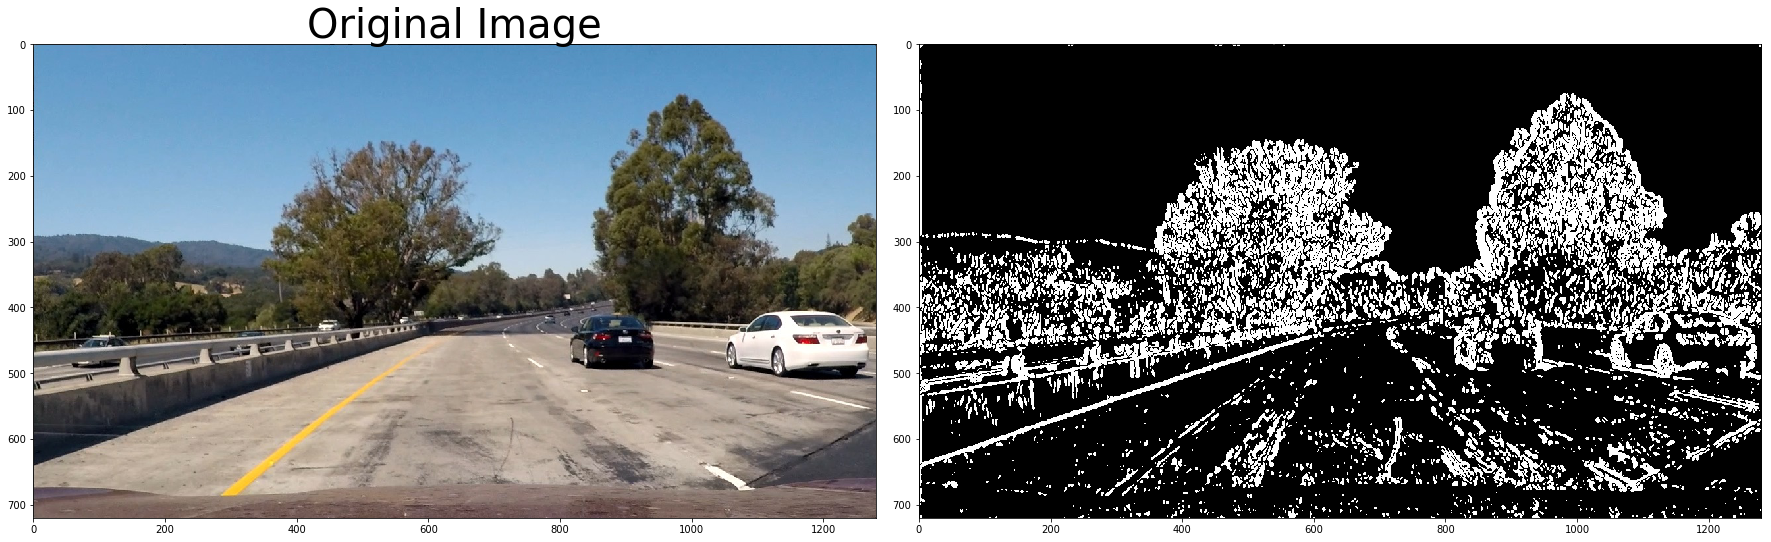

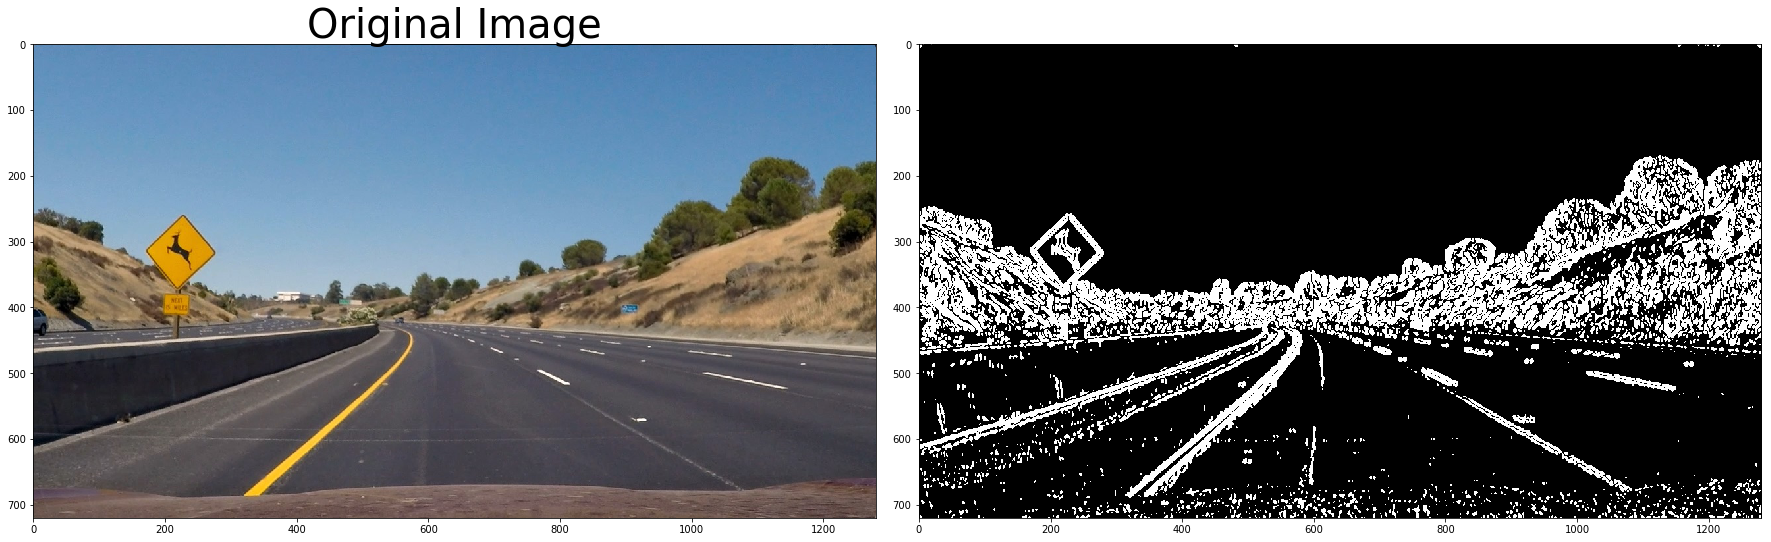

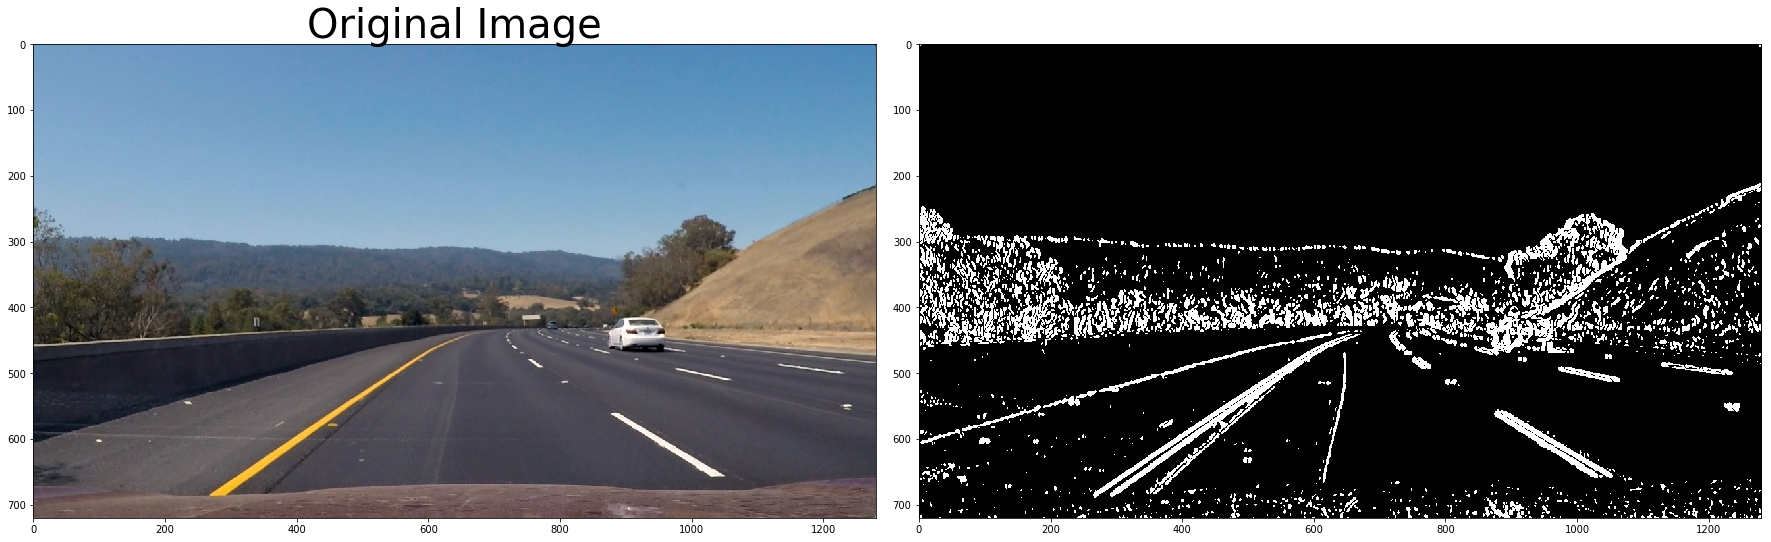

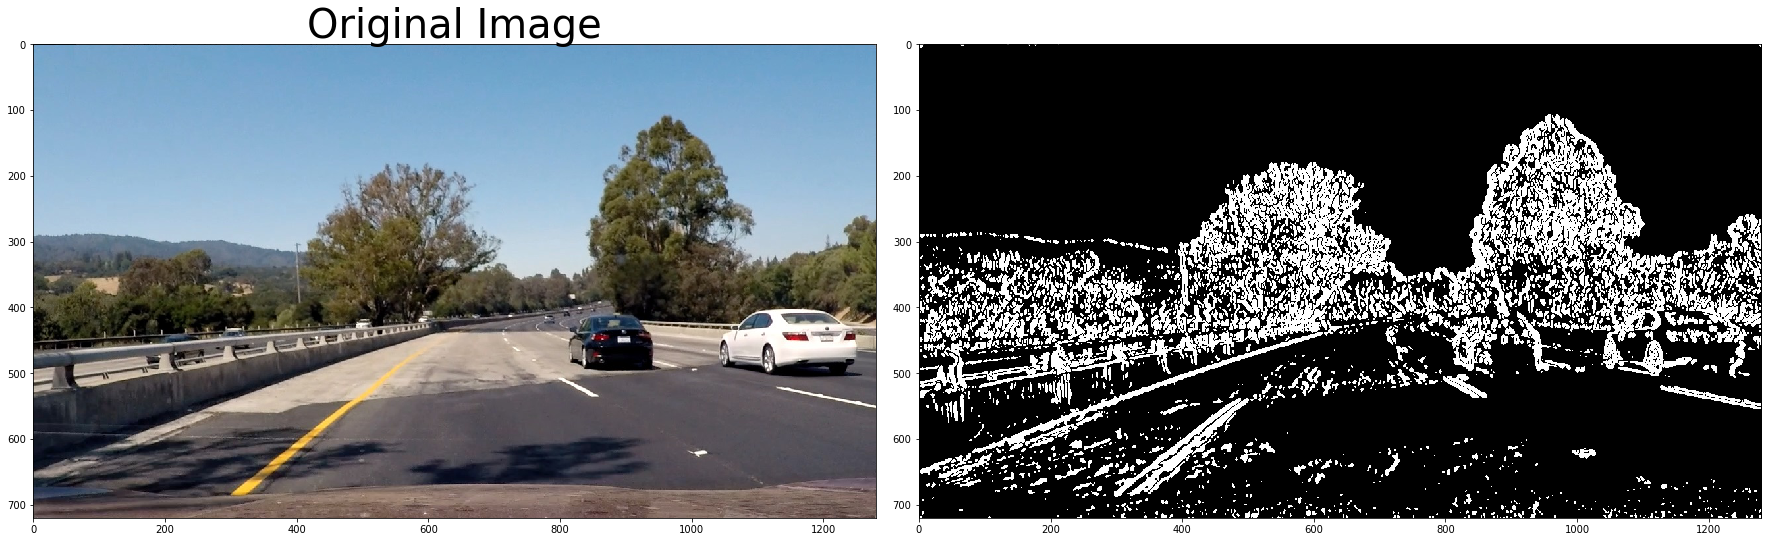

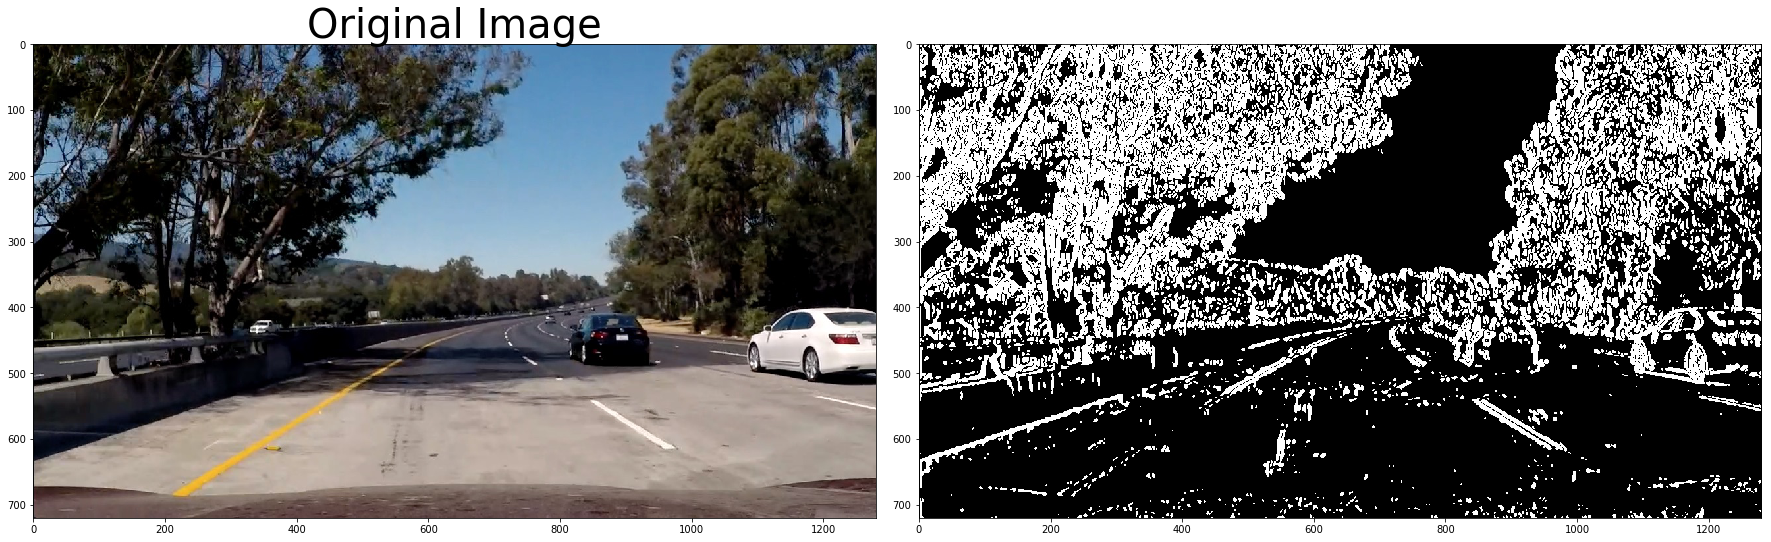

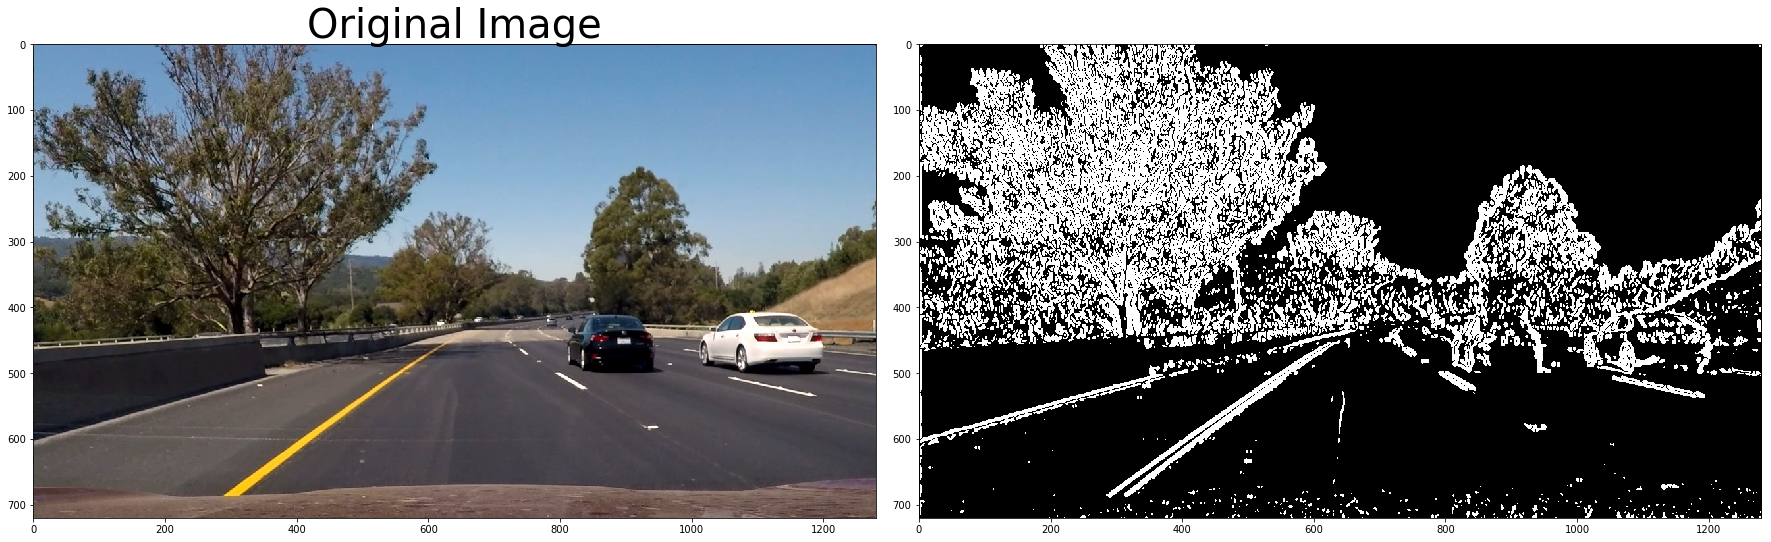

In [397]:
test_images=glob.glob('test_images/*.jpg')
test_out_image=[]
test_img_unwrap=[]
top_down_images_unwrap=[]
perspective_M_unwraps=[]
perspective_wrapped_image=[]

for fimg in test_images:
    
    img=mping.imread(fimg)

    test_out_image,color_binary=color_gradient(img,sobel_kernel=5)
    
    
    
    wraped, M_unwrap, Mvin, undistorted = corners_unwarp(test_out_image, 9, 6, mtx, dist)
    
    test_img_unwrap.append(wraped)
    
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=40)
    
    ax2.imshow(test_out_image,cmap='gray')
    ax3.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
      
    


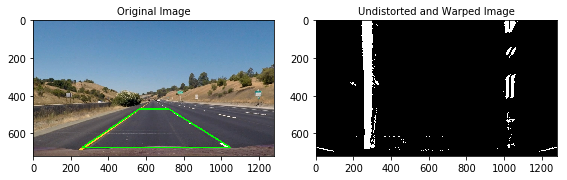

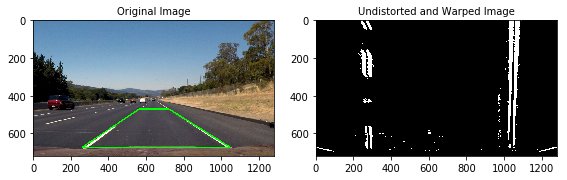

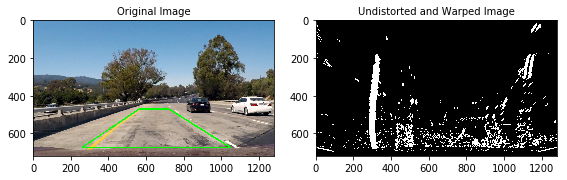

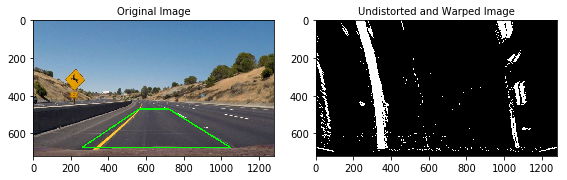

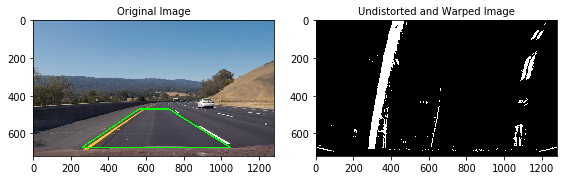

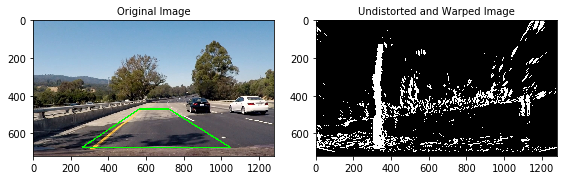

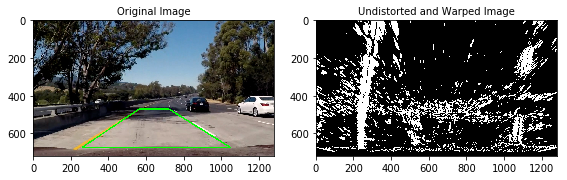

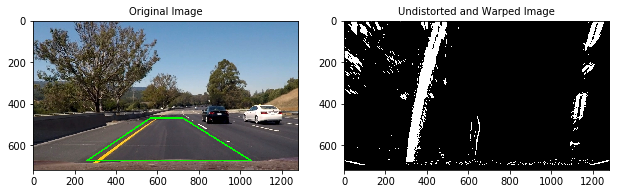

In [395]:
test_images=glob.glob('test_images/*.jpg')
for fimg in test_images:
    
    img=mping.imread(fimg)
#     src_topleft=(585, 465)
#     src_topright=(695, 465)
#     src_bottomright=(1048, 674)
#     src_bottomleft=(203, 720)
    src_topleft=(565, 470)
    src_topright=(720, 470)
    src_bottomright=(1048, 674)
    src_bottomleft=(260, 674)
    wraped, M_unwrap, Mvin, undistorted = corners_unwarp(img, 9, 6, mtx, dist)
    
    test_out_image,color_binary=color_gradient(wraped,sobel_kernel=5)
    srcplot = np.array( [[src_topleft,src_topright,src_bottomright,src_bottomleft]] , np.int32)
    copywpd = np.copy(img)
    ply_warped=cv2.polylines(copywpd,srcplot,True,(0,255,0),5)


    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
    f.tight_layout()
    ax1.imshow(ply_warped)
#     plt.plot( ,x,'r')
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(test_out_image,cmap='gray')
    ax2.set_title('Undistorted and Warped Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [377]:
binary_warped=test_img_unwrap[1]

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

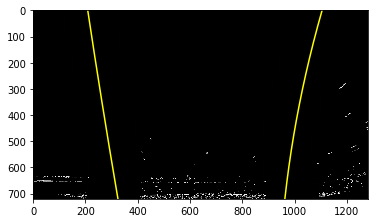

In [333]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [334]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

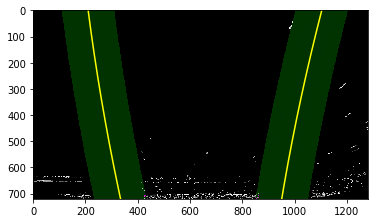

In [335]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

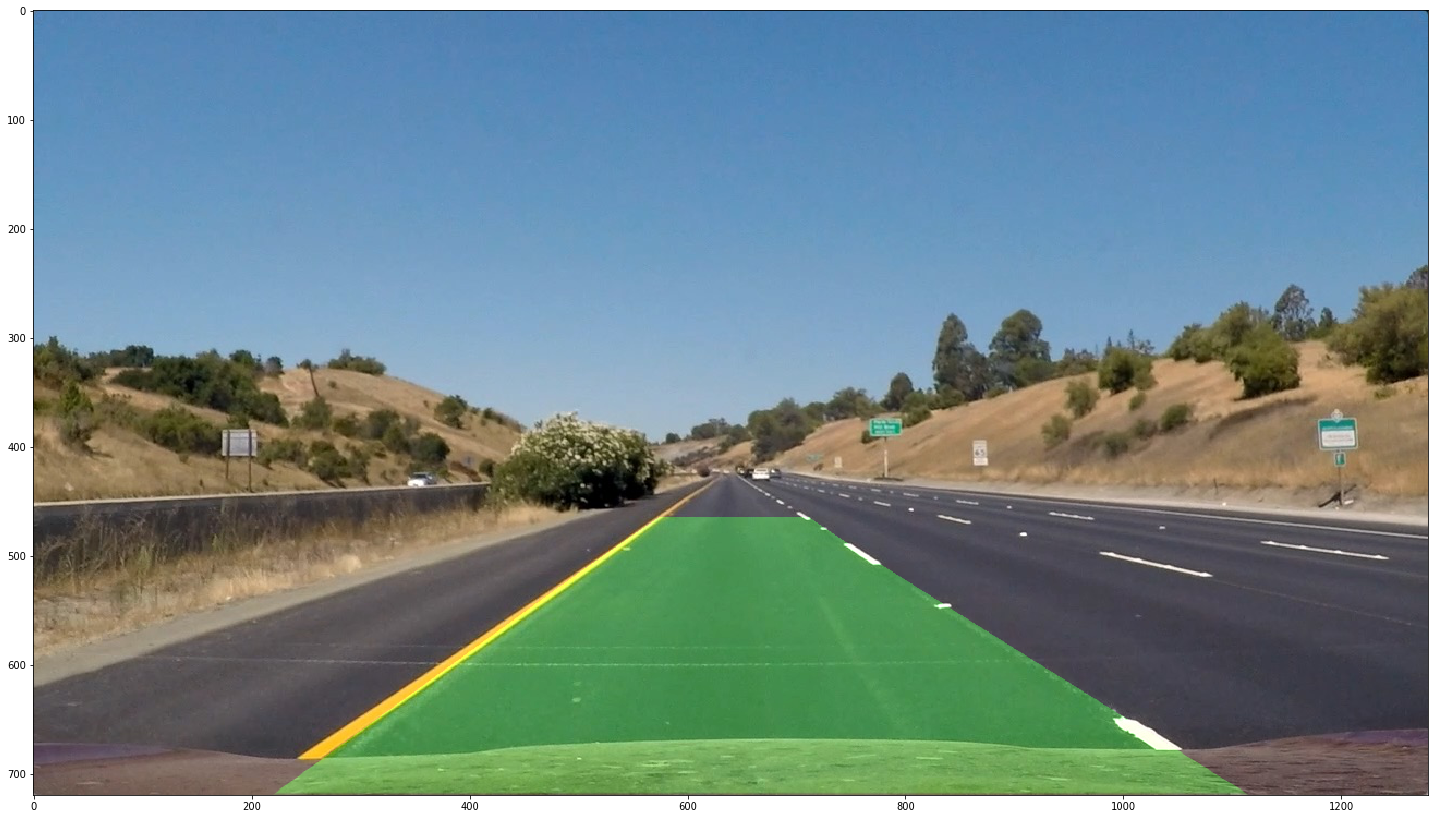

In [338]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Mvin, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(mping.imread(test_images[0]), 1, newwarp, 0.3, 0)

plt.figure(figsize=(25,25))
plt.imshow(result)

In [ ]:
def find_lanes(binary_warped):
    
    #for binary_warped in top_down_images_unwrap:
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=1)
    #plt.plot(histogram)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)       
    
    return left_lane_inds,right_lane_inds